In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from src.data.feature_extractor import FeatureExtractor
from src.data.importer import DataImporter
from src.data.ratings_dataset import RatingsDataset
from src.model.candidate_generation import CandidateGeneration
from src.trainer import Trainer
from src.utils import get_device
from src.model.approx_knn import ApproxKNN
from src.eval.rank_evaluator import RankEvaluator

/Users/loten.noy/.local/share/virtualenvs/recsys-3639-final-project-U-x006ej/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Fetch MovieLens100k data

In [4]:
data_importer = DataImporter('http://files.grouplens.org/datasets/movielens/ml-100k.zip')
users_df, movies_df, genres, ratings_df = data_importer.import_data()

Data already exists


### Generate features and create examples df

In [5]:
f_extractor = FeatureExtractor(window_size=50)
examples_df = f_extractor.fit_transform(
    genres=genres,
    movies_df=movies_df,
    users_df=users_df,
    ratings_df=ratings_df
)

One-Hot user occupation matrix shape (943, 21)
One-Hot user gender matrix shape (943, 2)
One-Hot user geo area matrix shape (943, 4)
Using 108 examples per user_id
Using 25 examples per label
Examples shape  (38050, 7)


## Split train/validation examples

In [15]:
train_df, val_df = train_test_split(examples_df)

# Train Loader
train_dataset = RatingsDataset.from_df(train_df)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Validation Loader
val_dataset = RatingsDataset.from_df(val_df)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

### Train Candidate generation model

In [7]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256
USER_DIM = 64
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

In [8]:
device = get_device()

model = CandidateGeneration(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is not available.  Training on CPU ...


In [9]:
trainer = Trainer(model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=7)

Epoch 1/7, train loss: 7.4264, val loss: 7.4274, time: 8.38s
Epoch 2/7, train loss: 7.4202, val loss: 7.4209, time: 8.22s
Epoch 3/7, train loss: 7.4139, val loss: 7.4145, time: 10.04s
Epoch 4/7, train loss: 7.4070, val loss: 7.4086, time: 9.73s
Epoch 5/7, train loss: 7.4019, val loss: 7.4049, time: 8.56s
Epoch 6/7, train loss: 7.3988, val loss: 7.4039, time: 10.81s
Epoch 7/7, train loss: 7.3966, val loss: 7.4001, time: 8.64s


<AxesSubplot:>

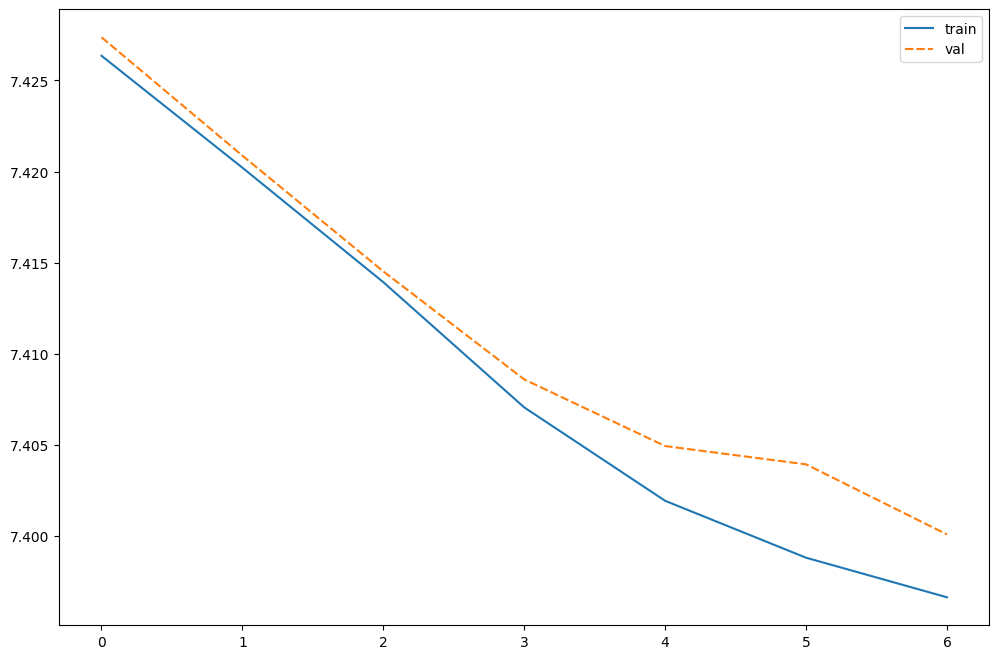

In [10]:
_, ax = plt.subplots(1, figsize=(12, 8))
sns.lineplot(data=pd.DataFrame({'train': train_losses, 'val': val_losses}), ax=ax)

### KNN for Inference time


In [16]:
k = 10
rank_evaluator = RankEvaluator(top_k=k, device=device)
rank_evaluator.fit(model)

In [18]:
print(f'validation mrr @ {k}: ', rank_evaluator.mrr(val_loader))
print(f'validation hit rate @ {k}: ', rank_evaluator.hit_rate(val_loader))

validation mrr @ 10:  0.05810271674080899
validation hit rate @ 10:  0.08777640716374269
